<a href="https://colab.research.google.com/github/Jackilion/flower-ddim/blob/master/DDIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Denoising Diffusion Implicit Model
In diesem Notebook soll es darum gehen, die Grundlagen der Technologie von den zurzeit viel bepriesenen Image Generator Modellen wie StableDiffusion zu verstehen.

Jeder Code Block kann durch klicken des "Play" Buttons oben Links ausgeführt werden. Es ist wichtig die Blöcke in der richtigen Reihenfolge auszuführen, ansonsten kann es zu Fehlern kommen.




##Import und Setup

Jedes Programm startet mit sogenannten Imports. Hierbei handelt es sich um das Laden von anderen, bereits programmierten Scripts.
In unserem Fall benutzen wir TensorFlow, ein Framework von Google, welches dazu dient Machine Learning Modelle zu programmieren.

Außerdem werden hier 2 Scripte geladen, die das eigentliche DDIM implementieren. Dessen verständnis ist nicht notwendig, falls du neugierig bist und etwas python verstehst, kannst du aber gerne den Source code von "model.py" und "diffusion_model.py" anschauen.

In [ ]:
import tensorflow as tf #Dieses Package definiert die eigentlichen neuronalen Netzstrukturen, sowie Datentypen und Rechenoperationen um sie zu manipulieren
import tensorflow_datasets as tfds #Dieses Package dient dem Download von Datensets, damit wir sie nicht per Hand downloaden müssen
import matplotlib.pyplot as plt #Ein Package, welches dem plotten von Daten dient. Wir benutzen es um die Bilder aus dem Datenset zu plotten, sowie unsere Trainingsergebnisse
import keras #Ein High Level Framework welches auf TensorFlow aufbaut. Hat viele nützliche Funktionen die uns das Leben erleichtern

import model
from diffusion_model import DiffusionModel

Als nächstes müssen wir unsere trainingsdaten Laden. In diesem Fall benutzen wir das Image set "Oxford flowers 102", ein Datenset mit etwa 6000 Bildern von Blüten.

Im nächsten code Block wird das Datenset heruntergeladen (was eine weile dauern kann), und ein paar Beispielbilder ausgegeben:

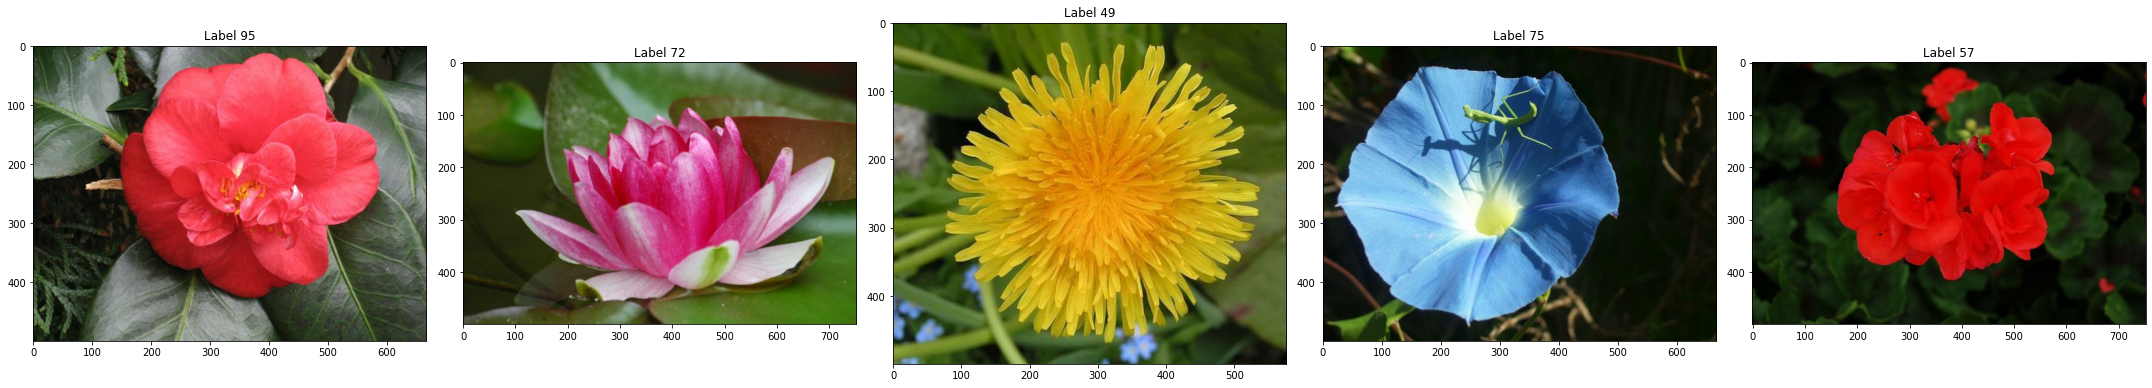

In [ ]:
dataset = tfds.load("oxford_flowers102", split="train[:80%]+validation[:80%]+test[:80%]", shuffle_files=True)

plt.rcParams["figure.figsize"] = [30, 15]
plt.rcParams["figure.autolayout"] = True
ctr = 0
for data in dataset:
  image = data["image"]
  image = image.numpy()
  plt.subplot(1, 5, ctr+1)
  plt.title('Label {}'.format(data["label"]))
  plt.imshow(image, cmap=plt.cm.binary)
  ctr += 1
  if ctr == 5:
    break

Die Nummer die neben dem Label ausgegeben wird entspricht der "Klasse" der dieses Bild angehört. In diesem Fall steht die Nummer für eine bestimmte Pflanzenart. Diese Labels sind wichtig wenn man z.B. ein neuronales Netz bauen möchte, was die Pflanzenart anhand eines Bildes der Blüte erkennt. Dann kann man sie benutzen um dem Netz feedback zu geben ob es richtig oder falsch liegt.

Außerdem sind sie wichtig wenn man bestimmte Blüten generieren möchte. Beispielsweise wäre es cool dem Netz sagen zu können man möchte gerne ein Bild einer Sonnenblume haben. Dies ist mit DDIM Models möglich, aber nicht Teil dieses Notebooks. Entwickelt man diese Technik dann weiter, kann man sogar Text-to-Image generation machen, wie z.B. StableDiffusion von OpenAI.





####<font color="blue">Frage: Was Fällt auf bei den Bildern auf was für unser Netz relevant sein könnte?</font>


<font color="blue">*Antwort: Die Bilder haben verschiedene Größen. Das ist ein Problem für neuronale Netzwerke. Denn diese Erwarten einen Input von immer gleicher größe. Schließlich lernen sie exakte operationen auf dem Input durchzuführen. Deshalb müssen wir bevor wir loslegen können die Bilder alle auf die selbe Größe bringen.*</font>

## Vorverarbeitung der Daten

Dies ist ein wichtiger Teil in Machine Learning. Selbst wenn das neuronale Netz einwandfrei funktioniert, kann es sein dass das Training fehl schlägt, wenn es Probleme mit dem Datenset gibt. Dies beinhaltet das sogenannte normalisieren von Daten, aber auch eine Analyse des Datensets selbst. Gibt es vielleicht einen möglichen bias?

Beispiel hier wäre ein oft genutztes Datenset: CelebA
Ein Datenset mit Gesichtern von Berühmtheiten. Es wird oft benutzt um facial recognition oder generation zu trainieren. Allerdings hat es einen klaren bias:

####<font color="blue">Frage: Welchen bias erwartest du in einem Datenset von Gesichtern von berühmten Personen?</font>

<font color="blue">*Berühmtheiten haben oft ein sehr symmetrisches Gesicht und sind überwiegend weiß. Dies hat in der Vergangenheit dazu geführt, dass z.B. Facial Login methoden auf Smartphones bei nicht-weißen Personen wesentlich schlechter funktioniert haben.*</font>

####<font color="blue">Frage: Welchen bias erwartest du in unserem Datenset?</font>

<font color="blue">*Antwort: Nicht jede Pflanzenart ist hier gleich verteten. Viele sogar gar nicht. Außerdem Blühen Pflanzen zu verschiedenen Tages/ Jahreszeiten, was für verschiedene Lichtverhältnisse beim aufnehmen der Photos sorgt.*</font>

###Normalisieren der Bilder

In unserem Fall geben wir uns mit dem Normalisieren der Bilder zufrieden. Das bedeutet hier, das alle Bilder auf die selben Maße zugeschnitten werden. Wir müssen hier leider auf 64x64 zurückgreifen. Dies ist der Performance geschuldet, denn wir müssen die Trainingszeit stark optimieren um im Rahmen dieses Workshops überhaupt Ergebnisse zu erhalten. Falls du zuhause nochmal rumspielen möchtest, versuche doch mal im nachfolgenden code block die IMG_SIZE Variable auf 128 oder 256 zu setzen.

Außerdem werden die Farbkanäle der Bilder auf 1 normiert. Normalerweise werden Farben im RGB-Format (Rot-Gelb-Grün) kodiert, auf einer Skala von 1-255. Ein RGB Wert von 0, 0, 0 bedeutet z.B. weder Rot, noch Gelb, noch Grün ist vorhanden, und die Farbe ist demnach schwarz.
Neuronale Netzwerke lieben input der zwischen 0 und 1 liegt. deshalb teilen wir jeden RGB wert durch 255. damit ist z.B. 255, 255, 255 auf 1, 1, 1 geschrumpft. Die Information ist die selbe, aber es erleichtert das Training.

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 128

def format_image(data):
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


training_set = (dataset
                   .map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
                   .cache()
                   .repeat(5)
                   .shuffle(10 * BATCH_SIZE)
                   .batch(BATCH_SIZE, drop_remainder=True)
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
)

##Definition des Models & Training

Nun geht es endlich an das eigentliche Model. Die eigentliche implementierung führt hier ein wenig weit. Bei interesse kannst du gerne einen Blick in die scripts "diffusion_model.py", in der der Trainingsprozess definiert ist, sowie "model.py", in dem das eigentliche neuronale netz gebaut wird werfen.

Für unsere Zwecke reicht ein high-level Überblick über das Netzwerk.
Wie in der Einführung erklärt, beruht ein Diffusion Model auf einem UNet.
Das bedeutet der Input besitzt die selben dimensionen (in unserem Fall 64x64) wie der output. Im innern des Netzwerks werden dann die dimensionen des Inputs Schritt für Schritt erniedrigt, und dann wieder erhöht. Dies führt dazu, dass das Model lernen muss, wesentliche Informationen in kondensierter Form darzustellen. Ein Mensch merkt sich ein Bild auch nicht Pixel für Pixel. Vielmehr benutzen Menschen abstrakte Aussagen, wie z.B. "Das Bild zeigt eine schwebende, rote Rose über dem offenen Meer". Neuronale Netze verarbeiten Informationen zwar ganz anders als wir, dennoch müssen auch sie Lernen, welche Informationen wichtiger sind als andere.

#### <font color="blue">Frage: Welche Abfolge von dimensionen hälst du im Inneren unseres UNets für angemessen?</font>

<font color="blue">*Die input dimensionen sind 64x64. Wir wollen diese dimensionen schrumpfen lassen und dann wieder bei 64 herauskommen. Deshalb bietet sich eine Abfolge von 64 -> 32 -> 16 -> 8 -> 16 -> 32 -> 64 an.*

*Diese Zahlen müssen nicht zwangsläufig Potenzen von 2 sein. Theoretisch könnte man auch 64 -> 30 -> 20 -> 10 -> 20 ->30 -> 64 benutzen. Allerdings haben Potenzen von 2 zahlreiche Vorteile in Datenverarbeitungen.*</font>

#### Das Training:
Das ausführen des folgenden codeblocks definiert das Model, und startet das Training. Dies kann mehrere Minuten dauern. Wir haben versucht das Training soweit wie möglich zu optimieren. Das führt allerdings zu suboptimalen Ergebnissen. Wenn du die Grenzen des Models austesten möchtest, dann setze oben die IMG_SIZE auf 256, die UNET_SHAPE auf [96, 128, 192] und EPOCHS auf mindestens 30

Während das Training läuft werden nach jeder Epoche ein paar Beispielbilder angezeigt. Diese zeigen, was das Model zu der jeweiligen Epoche kann. Du solltest beobachten können, wie die Bilder von Epoche zu Epoche besser werden.

Damit du nicht zu lange wartest, solltest du ruhig schonmal zu dem Abschnitt "Ergebnisse" vorspringen. Das gesamte Training sollte ca. 5-10 minuten dauern.

Epoch 1/5
255/255 [==============================] - ETA: 0s - noise_loss: 0.1421

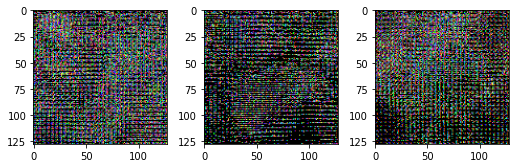

255/255 [==============================] - 350s 1s/step - noise_loss: 0.1421
Epoch 2/5
255/255 [==============================] - ETA: 0s - noise_loss: 0.0821

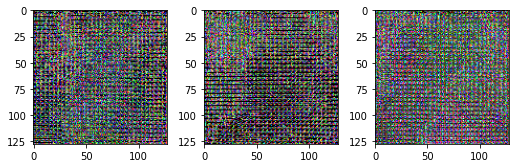

255/255 [==============================] - 347s 1s/step - noise_loss: 0.0821
Epoch 3/5
255/255 [==============================] - ETA: 0s - noise_loss: 0.0754

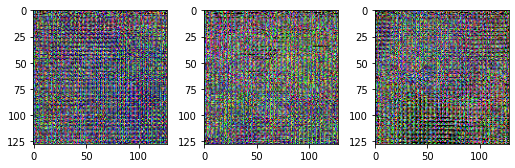

255/255 [==============================] - 348s 1s/step - noise_loss: 0.0754
Epoch 4/5
255/255 [==============================] - ETA: 0s - noise_loss: 0.0719

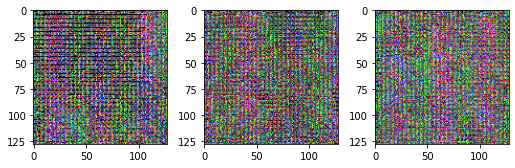

255/255 [==============================] - 347s 1s/step - noise_loss: 0.0719


In [ ]:
UNET_SHAPE = [16, 24, 32]
BLOCK_DEPTH = 2
EPOCHS = 10

model = DiffusionModel(IMG_SIZE, UNET_SHAPE, BLOCK_DEPTH, BATCH_SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-3
), loss=keras.losses.mean_absolute_error )

model.fit(training_set, epochs=EPOCHS, callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images)])

##Ergebnisse